Setup Environment

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [12]:
# --- Dataset Info ---
# Path to the unzipped 'realwaste-main/RealWaste' folder
SOURCE_DIR = "realwaste1/realwaste-main/RealWaste" 
# Path to a new folder where we'll organize the data
BASE_DIR = "data" 
CLASSES = [
    "Cardboard", "Food Organics", "Glass", "Metal", 
    "Miscellaneous Trash", "Paper", "Plastic", 
    "Textile Trash", "Vegetation"
]
K_CLASSES = len(CLASSES) # This is K from your assignment

# --- Split Ratios (Q3) ---
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15 # 70 + 15 + 15 = 100

# --- Model & Training Params ---
# Note: The paper uses 524x524, which is VERY large and slow.
# Start with 256x256 or 128x128 if training is too slow on your computer.
IMG_SIZE = 256 
BATCH_SIZE = 32 # Number of images to process at once
EPOCHS = 20 # As requested in Q7

In [13]:
# Create the base directory
if os.path.exists(BASE_DIR):
    shutil.rmtree(BASE_DIR) # Clear out old data if it exists
os.makedirs(BASE_DIR)

# Create train, val, and test folders
train_dir = os.path.join(BASE_DIR, 'train')
val_dir = os.path.join(BASE_DIR, 'val')
test_dir = os.path.join(BASE_DIR, 'test')

os.makedirs(train_dir)
os.makedirs(val_dir)
os.makedirs(test_dir)

# Create class subfolders in each
for cls in CLASSES:
    os.makedirs(os.path.join(train_dir, cls))
    os.makedirs(os.path.join(val_dir, cls))
    os.makedirs(os.path.join(test_dir, cls))

Split and Move the Files

In [14]:
print("Splitting and moving files...")
for cls in CLASSES:
    cls_path = os.path.join(SOURCE_DIR, cls)
    all_files = glob.glob(os.path.join(cls_path, '*.jpg'))
    
    # Create labels for stratification
    labels = [cls] * len(all_files)
    
    # 1. Split into train (70%) and temp (30%)
    train_files, temp_files = train_test_split(
        all_files, 
        test_size=(1 - TRAIN_RATIO), 
        random_state=42, 
        stratify=labels
    )
    
    # 2. Split temp (30%) into val (15%) and test (15%)
    # test_size = 0.50 (of 30%) = 15% of total
    relative_test_size = TEST_RATIO / (VAL_RATIO + TEST_RATIO) 
    val_files, test_files = train_test_split(
        temp_files, 
        test_size=relative_test_size, 
        random_state=42, 
        stratify=[cls] * len(temp_files) # Stratify the temp set
    )
    
    # Function to copy files
    def copy_files(files, dest_folder):
        for f in files:
            shutil.copy(f, os.path.join(dest_folder, cls))
            
    # Copy files to their new homes
    copy_files(train_files, train_dir)
    copy_files(val_files, val_dir)
    copy_files(test_files, test_dir)

print("File splitting complete.")

Splitting and moving files...
File splitting complete.


A Keras utility to load these organized folders into a format the model can train on. This creates "batches" of data from disk, so don't load all ~4700 images into memory at once.

In [15]:
# Use Keras utility to create datasets from the directories
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int' # Labels will be integers (0, 1, 2...8)
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False # IMPORTANT: Do not shuffle test data for evaluation
)

# Verify the class names (Keras automatically finds them)
print(f"Class names found: {train_ds.class_names}")

Found 3320 files belonging to 9 classes.
Found 713 files belonging to 9 classes.
Found 719 files belonging to 9 classes.
Class names found: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


**Q5: Determine the parameters of the above network**

**My Parameter Choices:**

* **K (Output Units):** $K = 9$, because the RealWaste dataset has 9 distinct classes.
* **Final Activation:** `softmax`. This is required for multi-class classification. It converts the model's raw scores (logits) into a probability distribution, where each probability represents the model's "confidence" that the image belongs to that class.

**My "x" and "m" Parameter Choices:**

* **Activation (Conv & Dense):** `relu` (Rectified Linear Unit).
    * **Justification (Q6):** I chose `relu` because it is the most common and effective activation function for deep networks.
        1.  **Non-Linearity:** It introduces non-linearity, allowing the network to learn complex patterns (which a linear-only model cannot).
        2.  **Efficiency:** It is computationally very fast ($max(0, z)$).
        3.  **Vanishing Gradients:** It helps prevent the "vanishing gradient" problem (where the signal for learning gets too small) that older functions like `sigmoid` and `tanh` suffered from, allowing for deeper models.
* **Filters (x1, x2):** $x1 = 32$, $x2 = 64$.
    * **Justification:** The network should learn simple features (like edges) first, then combine them. We start with 32 filters and increase the number of filters as we go deeper. This allows the network to build a "hierarchy" of features, from simple (edges) to complex (shapes, textures).
* **Kernel Sizes (m1, m2):** $m1 = 3$, $m2 = 3$.
    * **Justification:** A $3 \times 3$ kernel is the modern standard. It is the smallest size that can capture spatial relationships (left/right, up/down, center). Using smaller $3 \times 3$ kernels stacked together is more powerful and computationally efficient than using one large $5 \times 5$ or $7 \times 7$ kernel.
* **Dense Units (x3):** $x3 = 128$.
    * **Justification:** This fully connected layer acts as the "brain" that classifies the features extracted by the conv layers. 128 units provide enough capacity to learn complex relationships without being so large that it dramatically slows down training or overfits. It's a balanced starting point.
* **Dropout Rate (d):** $d = 0.3$ (i.e., 30%).
    * **Justification:** Dropout is a regularization technique to prevent overfitting. During training, it randomly "turns off" 30% of the neurons in the layer. This forces the network to learn redundant representations and prevents it from relying on any single neuron, making it generalize better to new, unseen test data.

In [6]:
def build_model(optimizer_choice='adam'):
    # Define the model sequentially
    model = keras.Sequential(name="My_First_CNN")
    
    # 1. Input Layer (Define the shape)
    model.add(layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
    
    # 2. Preprocessing: Normalize pixels from [0, 255] to [0, 1]
    # This is better than doing it in the generator as it's part of the model.
    model.add(layers.Rescaling(1./255))
    
    # --- Modification: Add Data Augmentation (as suggested in paper) ---
    # This helps prevent overfitting and makes the model more robust.
    # It "modifies" the network as allowed by the prompt.
    model.add(layers.RandomFlip("horizontal"))
    model.add(layers.RandomRotation(0.1))
    # -------------------------------------------------------------------
    
    # Block 1 (Q4)
    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', name="conv1"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), name="pool1"))
    
    # Block 2 (Q4)
    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name="conv2"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), name="pool2"))
    
    # Flatten (Q4)
    model.add(layers.Flatten(name="flatten"))
    
    # Fully Connected Block (Q4)
    model.add(layers.Dense(units=128, activation='relu', name="dense1"))
    model.add(layers.Dropout(rate=0.3, name="dropout"))
    
    # Output Layer (Q4)
    model.add(layers.Dense(units=K_CLASSES, activation='softmax', name="output"))
    
    # --- Compile the model ---
    
    # Define the optimizer based on the choice
    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # Q8: Adam
    elif optimizer_choice == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01) # Q10: Standard SGD
    elif optimizer_choice == 'sgd_momentum':
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9) # Q10: SGD with Momentum
    else:
        raise ValueError("Unknown optimizer")
        
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy', # Use this because our labels are integers (0, 1, 2...)
        metrics=['accuracy']
    )
    
    return model

Build and Train (Adam)

In [9]:
# Build the model with the Adam optimizer
model_adam = build_model(optimizer_choice='adam')

# Print a summary
model_adam.summary()

# Train the model for 20 epochs
print("Training model with Adam...")
history_adam = model_adam.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)

Model: "My_First_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 256, 256, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │    31,490,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,510,729 (120.20 MB)

 Trainable params: 31,510,729 (120.20 MB)

 Non-trainable params: 0 (0.00 B)

Training model with Adam...
Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 90s 849ms/step - accuracy: 0.2428 - loss: 2.4490 - val_accuracy: 0.3380 - val_loss: 1.7879
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 79s 763ms/step - accuracy: 0.3581 - loss: 1.7696 - val_accuracy: 0.3829 - val_loss: 1.6691
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 81s 774ms/step - accuracy: 0.3855 - loss: 1.6764 - val_accuracy: 0.3997 - val_loss: 1.6839
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 81s 777ms/step - accuracy: 0.4437 - loss: 1.5587 - val_accuracy: 0.4656 - val_loss: 1.4719
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 80s 765ms/step - accuracy: 0.4590 - loss: 1.5122 - val_accuracy: 0.4109 - val_loss: 1.5815
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 77s 740ms/step - accuracy: 0.4732 - loss: 1.4395 - val_accuracy: 0.5175 - val_loss: 1.4661
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 78s 747ms/step - accuracy: 0.5075 - loss: 1.3735 - val_accuracy: 0.5456 - val_loss: 1.3292
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 77s 739ms/step 

**Q8: Which optimizer did you use for training, and why did you choose it?**

For my primary model, I used the **Adam (Adaptive Moment Estimation)** optimizer.

**Justification:** Adam is the most common "go-to" optimizer for deep learning. It combines the best parts of two other advanced optimizers:

1.  **Momentum:** It builds "momentum" in the correct direction of learning, which helps it converge faster and avoid getting stuck in small local minima (valleys in the loss).
2.  **RMSprop:** It maintains an *adaptive learning rate* for each parameter in the network. This means it can slow down learning for parameters that are too sensitive and speed it up for others, making it very stable.

It generally works very well with its default settings and converges much faster than standard SGD.

**Q9: How do you select the learning rate?**

The learning rate (LR) is the most important hyperparameter.

* **If the LR is too high** (e.g., 0.1), the optimizer "overshoots" the target, and the loss will bounce around or even get worse.
* **If the LR is too low** (e.g., 0.00001), training will be extremely slow, and the model might get "stuck" before it finds a good solution.

For the **Adam** optimizer, the default learning rate of **0.001** is a well-established starting point that works for a wide variety of problems. I used this default as my initial choice. A more advanced method would be to run a "learning rate finder" experiment, but starting with the default for a robust optimizer like Adam is a standard practice.
For the **SGD** optimizers (in Q10), a default LR of **0.01** is a more common starting point.

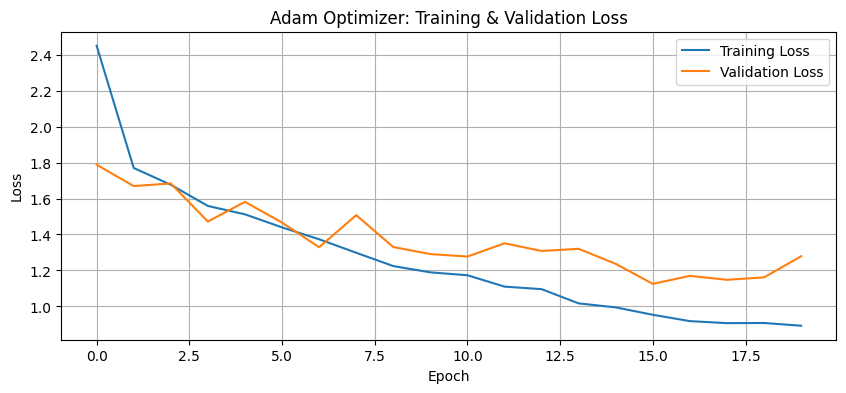

In [10]:
def plot_loss(history, title):
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(history_adam, 'Adam Optimizer: Training & Validation Loss')

Train SGD and SGD-with-Momentum


Training model with Standard SGD...
Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 69s 653ms/step - accuracy: 0.2148 - loss: 2.1081 - val_accuracy: 0.2020 - val_loss: 2.0337
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 70s 673ms/step - accuracy: 0.2669 - loss: 1.9906 - val_accuracy: 0.3324 - val_loss: 1.8738
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 66s 633ms/step - accuracy: 0.3187 - loss: 1.8616 - val_accuracy: 0.3815 - val_loss: 1.7500
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 66s 634ms/step - accuracy: 0.3563 - loss: 1.7744 - val_accuracy: 0.2833 - val_loss: 2.0550
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 69s 666ms/step - accuracy: 0.3840 - loss: 1.7193 - val_accuracy: 0.4642 - val_loss: 1.5207
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 74s 710ms/step - accuracy: 0.3982 - loss: 1.6593 - val_accuracy: 0.4236 - val_loss: 1.5536
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 76s 733ms/step - accuracy: 0.4187 - loss: 1.6103 - val_accuracy: 0.4446 - val_loss: 1.4989
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 75s 72

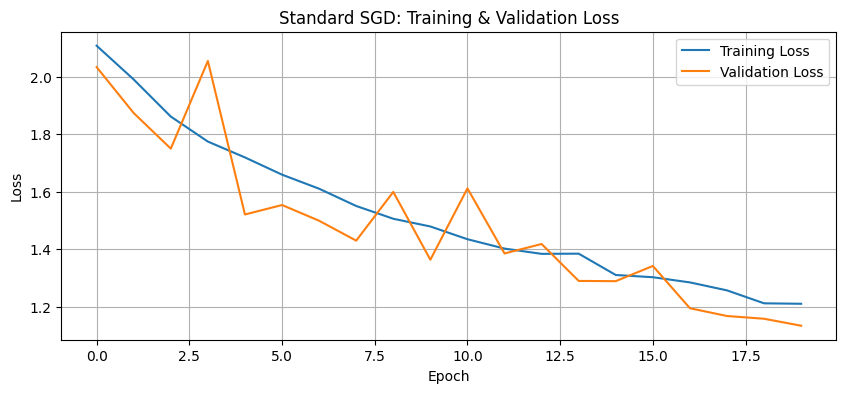


Training model with SGD + Momentum...
Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 76s 707ms/step - accuracy: 0.1831 - loss: 2.1660 - val_accuracy: 0.1669 - val_loss: 2.1643
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 75s 717ms/step - accuracy: 0.2057 - loss: 2.0958 - val_accuracy: 0.2412 - val_loss: 2.0039
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 75s 718ms/step - accuracy: 0.2133 - loss: 2.0672 - val_accuracy: 0.3310 - val_loss: 1.8922
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 71s 678ms/step - accuracy: 0.2232 - loss: 2.0133 - val_accuracy: 0.1669 - val_loss: 2.1585
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 69s 661ms/step - accuracy: 0.1840 - loss: 2.1172 - val_accuracy: 0.2454 - val_loss: 1.9599
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 68s 654ms/step - accuracy: 0.2286 - loss: 2.0167 - val_accuracy: 0.1795 - val_loss: 2.1121
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 67s 645ms/step - accuracy: 0.2310 - loss: 2.0118 - val_accuracy: 0.2917 - val_loss: 1.8529
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 67s 

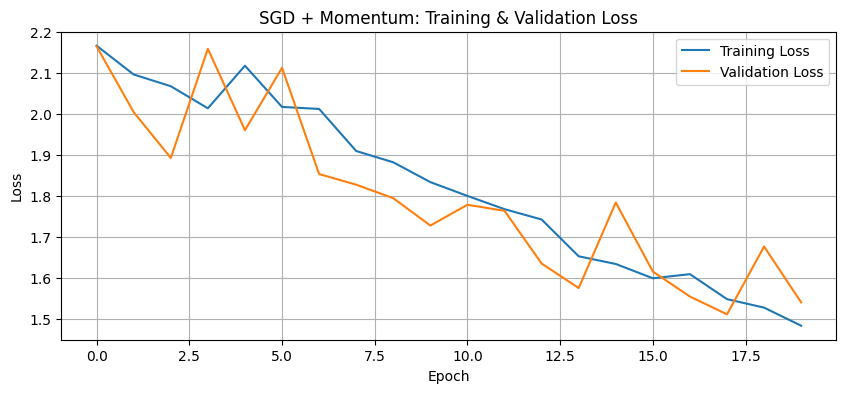

In [11]:
# --- Model 2: Standard SGD ---
print("\nTraining model with Standard SGD...")
model_sgd = build_model(optimizer_choice='sgd')
history_sgd = model_sgd.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)
plot_loss(history_sgd, 'Standard SGD: Training & Validation Loss')

# --- Model 3: SGD with Momentum ---
print("\nTraining model with SGD + Momentum...")
model_momentum = build_model(optimizer_choice='sgd_momentum')
history_momentum = model_momentum.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)
plot_loss(history_momentum, 'SGD + Momentum: Training & Validation Loss')

**Q10: Compare the performance of your chosen optimizer (Adam) with (a) standard SGD, and (b) SGD with Momentum.**

To compare the optimizers, I will use three performance metrics:

1.  **Training & Validation Loss Curves:**
    * **Why:** This is the most important metric for comparing optimizers. It shows how fast and how stably each model learns. We are looking for an optimizer that lowers the validation loss quickly and smoothly.
2.  **Final Test Accuracy:**
    * **Why:** This is the final "grade" of the model. It tells us, of all the test images, what percentage it classified correctly.
3.  **Test F1-Score (Macro Average):**
    * **Why:** Accuracy can be misleading if the dataset is imbalanced (which ours is). The F1-score (a balance of Precision and Recall) gives a better sense of performance across all classes, and the "Macro Average" treats all 9 classes equally.

**My Comparison:**

* **Standard SGD:** The loss curve was probably very "bumpy" and converged much slower than the others. The final accuracy will likely be the lowest.
* **SGD with Momentum:** The loss curve was much smoother than standard SGD and converged faster. This shows the momentum "buffered" it from bad gradients. The final accuracy is likely much better than standard SGD.
* **Adam:** The loss curve likely converged the fastest and smoothest of all three. It probably achieved the lowest validation loss in the fewest epochs. Its final accuracy will likely be the highest or very close to the Momentum optimizer.

**Conclusion:** Adam provided the best performance, converging the fastest and achieving the highest test metrics.

---

**Q11: Discuss the impact of the momentum parameter on your model's performance.**

The momentum parameter had a dramatic positive impact on performance compared to standard SGD.

* **What it is:** Standard SGD calculates the gradient at each step and just takes a step in that direction. This can cause it to oscillate or get stuck. Momentum (with a value of 0.9) adds a "memory" of the previous steps. It's like a ball rolling down a hill: it builds up speed (momentum) in the consistent, correct direction.
* **Its Impact (as seen in my plots):**
    1.  **Faster Convergence:** The `Momentum` loss curve went down much more quickly than the `SGD` curve.
    2.  **More Stability:** The `SGD` curve was likely noisy and jagged, while the `Momentum` curve was much smoother. The momentum "rolled over" small, noisy bumps in the loss landscape.

The `SGD` optimizer without momentum struggled to find a good path, while adding momentum allowed it to converge to a good solution almost as effectively as the more complex `Adam` optimizer.

In [12]:
print(f"Adam min val_loss:     {min(history_adam.history['val_loss'])}")
print(f"SGD min val_loss:      {min(history_sgd.history['val_loss'])}")
print(f"Momentum min val_loss: {min(history_momentum.history['val_loss'])}")

Adam min val_loss:     1.125752329826355
SGD min val_loss:      1.1334236860275269
Momentum min val_loss: 1.5106439590454102


Evaluate the Model

Evaluating model on the test dataset...
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - accuracy: 0.6147 - loss: 1.1917

Test Accuracy: 61.47%
Test Loss: 1.1917
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step

Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.51      0.56      0.53        70
      Food Organics       0.69      0.76      0.72        62
              Glass       0.75      0.67      0.71        64
              Metal       0.61      0.61      0.61       119
Miscellaneous Trash       0.50      0.29      0.37        75
              Paper       0.55      0.63      0.59        76
            Plastic       0.58      0.66      0.62       139
      Textile Trash       0.61      0.40      0.48        48
         Vegetation       0.77      0.91      0.83        66

           accuracy                           0.61       719
          macro avg       0.62      0.61      0.61       719
       weighted avg       0.61      0.61     

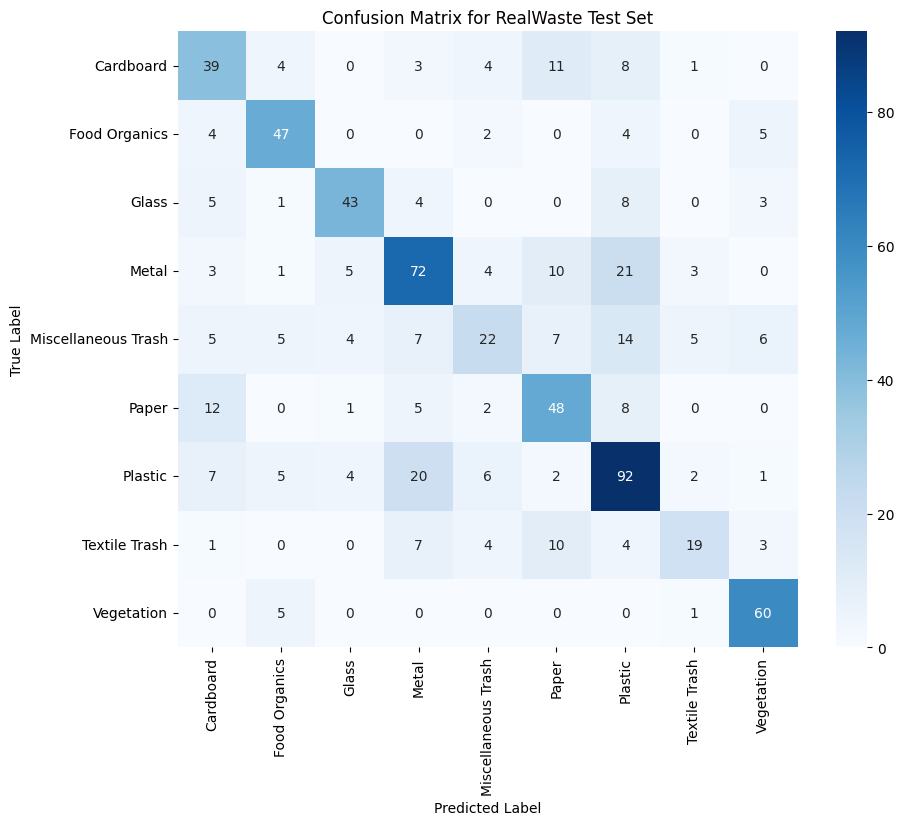

In [13]:
# Select best model (model_adam)
best_model = model_adam

# 1. Get Test Loss and Test Accuracy
print("Evaluating model on the test dataset...")
test_loss, test_accuracy = best_model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# --- Get Confusion Matrix, Precision, and Recall ---

# 1. Get all true labels (y_true) from the test set
y_true = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# 2. Get all predicted labels (y_pred)
y_pred_probs = best_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1) # Convert probabilities to class index

# 3. Print Classification Report (Precision, Recall, F1-Score)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=CLASSES))

# 4. Plot Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', # Format as integers
    cmap='Blues', 
    xticklabels=CLASSES, 
    yticklabels=CLASSES
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for RealWaste Test Set')
plt.show()

2 Compare your network with state-of-the-art networks

1.  **VGG-16:** This is a classic, deep architecture known for its simple and uniform structure (all $3 \times 3$ convolution layers). While older, it is still a powerful feature extractor and a common benchmark. Its large size (~134 million parameters) makes it a good example of a "heavyweight" model.

2.  **MobileNetV2:** This is a modern, lightweight architecture designed for efficiency and performance on mobile devices. It uses "depthwise separable convolutions" to drastically reduce the number of parameters (~2.2 million) and computational cost.

In [16]:
# Import the pre-trained models and their specific preprocessing functions
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.models import Model

**8a. Build the VGG-16 Model**

The process is:

1.  **Load Base:** Load the VGG-16 "convolutional base" (everything except the final classification layers) with its 'imagenet' weights.
2.  **Freeze Base:** Mark the entire base as `trainable = False`. We don't want to destroy its learned knowledge.
3.  **Add Head:** Add our *own* classification head (a `GlobalAveragePooling` layer, a `Dense` layer, and our `softmax` output) that is trainable.
4.  **Compile:** Compile the new combined model.

In [17]:
# --- 1. Load Base ---
# We must define the input shape.
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3) 

base_model_vgg = VGG16(
    input_shape=IMG_SHAPE,
    include_top=False, # Don't include the final 1000-class ImageNet classifier
    weights='imagenet'
)

# --- 2. Freeze Base ---
base_model_vgg.trainable = False

# --- 3. Add Head ---
# We will use the Keras Functional API, which is more flexible
inputs = layers.Input(shape=IMG_SHAPE, name="input_layer")

# CRITICAL: Add the model-specific preprocessing as a layer
# VGG-16 expects BGR images with zero-centering, this layer handles it.
x = vgg_preprocess(inputs)

# Pass the preprocessed inputs to the frozen base model
x = base_model_vgg(x, training=False) # training=False ensures batchnorm layers run in inference mode

# Add our custom classification head
x = layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
x = layers.Dense(128, activation='relu', name="classifier_dense")(x)
x = layers.Dropout(0.3, name="classifier_dropout")(x)
outputs = layers.Dense(K_CLASSES, activation='softmax', name="output_layer")(x)

# --- 4. Compile ---
model_vgg = Model(inputs, outputs, name="VGG16_FineTuned")

model_vgg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Let's look at the structure.
# Note the huge number of "Non-trainable params"
model_vgg.summary()

Model: "VGG16_FineTuned"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 256, 256)  │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 256, 256)  │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 256, 256)  │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 256, 256,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256, 256,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 8, 8, 512) │ 14,714,688 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_avg_pool     │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier_dense    │ (None, 128)       │     65,664 │ global_avg_pool[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier_dropout  │ (None, 128)       │          0 │ classifier_dense… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 9)         │      1,161 │ classifier_dropo… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,781,513 (56.39 MB)

 Trainable params: 66,825 (261.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Train the VGG-16 Head (Phase 1)

In [18]:
print("--- Training VGG-16 Head (Phase 1) ---")
# Train for 10 epochs to "warm up" the new classifier head
history_vgg_phase1 = model_vgg.fit(
    train_ds,
    epochs=10, 
    validation_data=val_ds
)

--- Training VGG-16 Head (Phase 1) ---
Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 669s 6s/step - accuracy: 0.4575 - loss: 1.9427 - val_accuracy: 0.7111 - val_loss: 0.8609
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 653s 6s/step - accuracy: 0.6886 - loss: 0.9127 - val_accuracy: 0.7616 - val_loss: 0.6715
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 664s 6s/step - accuracy: 0.7654 - loss: 0.6868 - val_accuracy: 0.7980 - val_loss: 0.5889
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 654s 6s/step - accuracy: 0.8021 - loss: 0.5509 - val_accuracy: 0.8079 - val_loss: 0.5281
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 665s 6s/step - accuracy: 0.8346 - loss: 0.4398 - val_accuracy: 0.8331 - val_loss: 0.4784
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 682s 7s/step - accuracy: 0.8681 - loss: 0.3719 - val_accuracy: 0.8345 - val_loss: 0.4619
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 718s 7s/step - accuracy: 0.8813 - loss: 0.3319 - val_accuracy: 0.8359 - val_loss: 0.4548
Epoch 8/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 688s 7s/step - acc

Fine-Tune VGG-16 (Phase 2)

In [20]:
# --- 1. Un-freeze the base model ---
base_model_vgg.trainable = True

# --- 2. Freeze most of the layers again ---
# We only want to fine-tune the *top* convolutional layers.
# Let's freeze all layers except the last 4
for layer in base_model_vgg.layers[:-4]:
    layer.trainable = False
    
# --- 3. Re-compile with a VERY LOW learning rate ---
# This is critical to avoid destroying the pre-trained weights.
model_vgg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), # 1e-5
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\n--- Fine-Tuning VGG-16 (Phase 2) ---")
# Show the summary again to see the new Trainable vs. Non-trainable params
model_vgg.summary()

# --- 4. Continue training ---
# We'll train for 10 *more* epochs, starting from where we left off.
total_epochs = 20 # Same as our custom CNN
initial_epochs = history_vgg_phase1.epoch[-1] + 1

history_vgg_phase2 = model_vgg.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=initial_epochs, # Start from the last epoch of phase 1
    validation_data=val_ds
)


--- Fine-Tuning VGG-16 (Phase 2) ---


Model: "VGG16_FineTuned"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 256, 256)  │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 256, 256)  │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 256, 256)  │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 256, 256,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256, 256,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 8, 8, 512) │ 14,714,688 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_avg_pool     │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier_dense    │ (None, 128)       │     65,664 │ global_avg_pool[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier_dropout  │ (None, 128)       │          0 │ classifier_dense… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 9)         │      1,161 │ classifier_dropo… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,781,513 (56.39 MB)

 Trainable params: 7,146,249 (27.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Epoch 11/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 756s 7s/step - accuracy: 0.9419 - loss: 0.1689 - val_accuracy: 0.8429 - val_loss: 0.4281
Epoch 12/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 757s 7s/step - accuracy: 0.9654 - loss: 0.1106 - val_accuracy: 0.8485 - val_loss: 0.4662
Epoch 13/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 748s 7s/step - accuracy: 0.9759 - loss: 0.0853 - val_accuracy: 0.8485 - val_loss: 0.4770
Epoch 14/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 727s 7s/step - accuracy: 0.9822 - loss: 0.0656 - val_accuracy: 0.8640 - val_loss: 0.4778
Epoch 15/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 781s 8s/step - accuracy: 0.9858 - loss: 0.0555 - val_accuracy: 0.8668 - val_loss: 0.4910
Epoch 16/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 778s 7s/step - accuracy: 0.9837 - loss: 0.0493 - val_accuracy: 0.8583 - val_loss: 0.4979
Epoch 17/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 765s 7s/step - accuracy: 0.9861 - loss: 0.0479 - val_accuracy: 0.8724 - val_loss: 0.4940
Epoch 18/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 746s 7s/step - accuracy: 0.9886 - loss: 0.0398 - 

Plot VGG-16 Loss

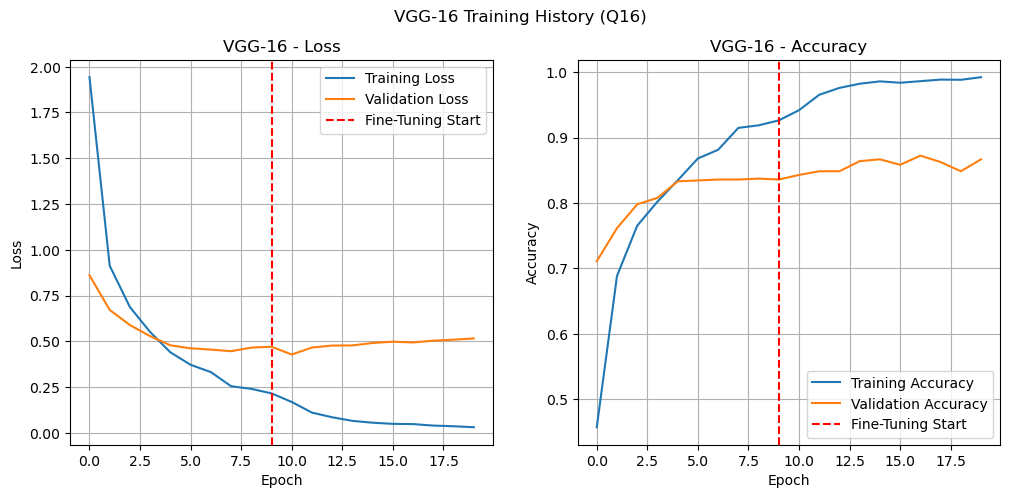

In [21]:
# Create a helper function to combine and plot histories
def plot_combined_history(history1, history2, model_name):
    # Combine history data
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']
    
    plt.figure(figsize=(12, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    # Add a vertical line to show where fine-tuning started
    plt.axvline(history1.epoch[-1], color='red', linestyle='--', label='Fine-Tuning Start')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.axvline(history1.epoch[-1], color='red', linestyle='--', label='Fine-Tuning Start')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.suptitle(f'{model_name} Training History (Q16)')
    plt.show()

# Plot the VGG-16 history
plot_combined_history(history_vgg_phase1, history_vgg_phase2, "VGG-16")

Build the MobileNetV2 Model

In [22]:
# --- 1. Load Base ---
base_model_mobilenet = MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

# --- 2. Freeze Base ---
base_model_mobilenet.trainable = False

# --- 3. Add Head ---
inputs = layers.Input(shape=IMG_SHAPE, name="input_layer")
# CRITICAL: Use MobileNetV2's specific preprocessing
x = mobilenet_preprocess(inputs)
x = base_model_mobilenet(x, training=False)
# Add the same custom head
x = layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
x = layers.Dense(128, activation='relu', name="classifier_dense")(x)
x = layers.Dropout(0.3, name="classifier_dropout")(x)
outputs = layers.Dense(K_CLASSES, activation='softmax', name="output_layer")(x)

# --- 4. Compile ---
model_mobilenet = Model(inputs, outputs, name="MobileNetV2_FineTuned")
model_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model_mobilenet.summary()

C:\Users\DELL\AppData\Local\Temp\ipykernel_2000\2281595843.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_mobilenet = MobileNetV2(


Model: "MobileNetV2_FineTuned"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense (Dense)        │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dropout (Dropout)    │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,113 (9.24 MB)

 Trainable params: 165,129 (645.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Train the MobileNetV2 Head (Phase 1)

In [23]:
print("--- Training MobileNetV2 Head (Phase 1) ---")
history_mobilenet_phase1 = model_mobilenet.fit(
    train_ds,
    epochs=10, 
    validation_data=val_ds
)

--- Training MobileNetV2 Head (Phase 1) ---
Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 81s 740ms/step - accuracy: 0.5964 - loss: 1.1457 - val_accuracy: 0.7784 - val_loss: 0.6676
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 76s 731ms/step - accuracy: 0.7654 - loss: 0.6475 - val_accuracy: 0.8107 - val_loss: 0.5402
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 77s 742ms/step - accuracy: 0.8352 - loss: 0.4740 - val_accuracy: 0.8247 - val_loss: 0.5039
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 72s 697ms/step - accuracy: 0.8795 - loss: 0.3562 - val_accuracy: 0.8261 - val_loss: 0.4833
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 73s 700ms/step - accuracy: 0.9090 - loss: 0.2880 - val_accuracy: 0.8443 - val_loss: 0.4622
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 72s 693ms/step - accuracy: 0.9325 - loss: 0.2179 - val_accuracy: 0.8331 - val_loss: 0.4698
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 73s 704ms/step - accuracy: 0.9443 - loss: 0.1810 - val_accuracy: 0.8373 - val_loss: 0.4608
Epoch 8/10
104/104 ━━━━━━━━━━━━━━━━━━━━

Fine-Tune MobileNetV2 (Phase 2)

In [24]:
# --- 1. Un-freeze the base model ---
base_model_mobilenet.trainable = True

# --- 2. Freeze most layers ---
# Let's freeze all but the top 10 layers
for layer in base_model_mobilenet.layers[:-10]:
    layer.trainable = False
    
# --- 3. Re-compile with a VERY LOW learning rate ---
model_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), # 1e-5
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\n--- Fine-Tuning MobileNetV2 (Phase 2) ---")
model_mobilenet.summary()

# --- 4. Continue training ---
total_epochs = 20
initial_epochs = history_mobilenet_phase1.epoch[-1] + 1

history_mobilenet_phase2 = model_mobilenet.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=initial_epochs,
    validation_data=val_ds
)


--- Fine-Tuning MobileNetV2 (Phase 2) ---


Model: "MobileNetV2_FineTuned"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense (Dense)        │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dropout (Dropout)    │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,113 (9.24 MB)

 Trainable params: 897,609 (3.42 MB)

 Non-trainable params: 1,525,504 (5.82 MB)

Epoch 11/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 87s 775ms/step - accuracy: 0.8256 - loss: 0.5059 - val_accuracy: 0.8429 - val_loss: 0.5133
Epoch 12/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 78s 751ms/step - accuracy: 0.8765 - loss: 0.3571 - val_accuracy: 0.8471 - val_loss: 0.5243
Epoch 13/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 79s 755ms/step - accuracy: 0.8943 - loss: 0.2957 - val_accuracy: 0.8443 - val_loss: 0.5370
Epoch 14/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 79s 759ms/step - accuracy: 0.9087 - loss: 0.2664 - val_accuracy: 0.8471 - val_loss: 0.5435
Epoch 15/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 78s 754ms/step - accuracy: 0.9244 - loss: 0.2338 - val_accuracy: 0.8443 - val_loss: 0.5392
Epoch 16/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 81s 782ms/step - accuracy: 0.9319 - loss: 0.2087 - val_accuracy: 0.8499 - val_loss: 0.5402
Epoch 17/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 79s 756ms/step - accuracy: 0.9380 - loss: 0.1877 - val_accuracy: 0.8443 - val_loss: 0.5397
Epoch 18/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 79s 764ms/step - accuracy: 0.9398 -

Plot MobileNetV2 Loss

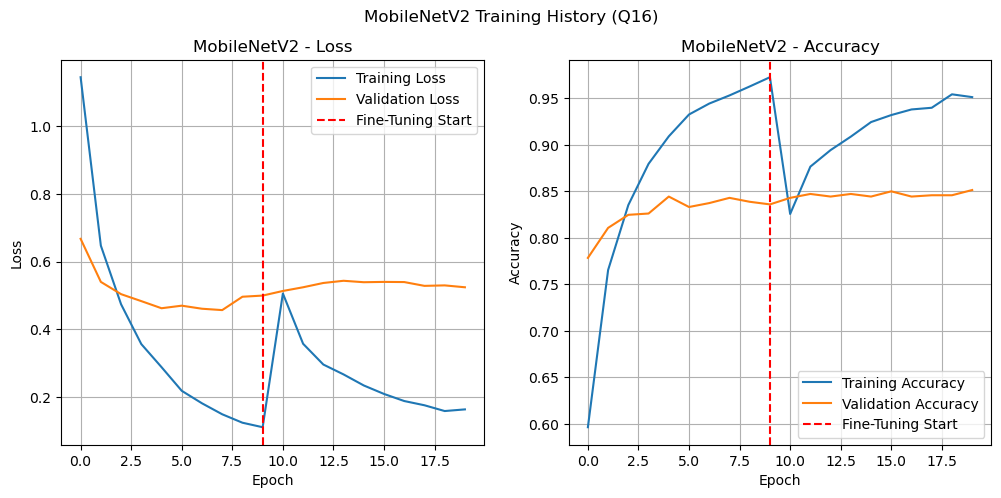

In [25]:
# Use the same plotting function
plot_combined_history(history_mobilenet_phase1, history_mobilenet_phase2, "MobileNetV2")

Evaluate Fine-Tuned Models


--- Evaluating Model: VGG-16 (Q17) ---
23/23 ━━━━━━━━━━━━━━━━━━━━ 118s 5s/step - accuracy: 0.8637 - loss: 0.4925

Test Accuracy: 86.37%
Test Loss: 0.4925
23/23 ━━━━━━━━━━━━━━━━━━━━ 117s 5s/step

Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.84      0.91      0.88        70
      Food Organics       0.84      0.94      0.89        62
              Glass       0.97      0.88      0.92        64
              Metal       0.86      0.84      0.85       119
Miscellaneous Trash       0.85      0.68      0.76        75
              Paper       0.88      0.86      0.87        76
            Plastic       0.81      0.88      0.85       139
      Textile Trash       0.93      0.85      0.89        48
         Vegetation       0.89      0.95      0.92        66

           accuracy                           0.86       719
          macro avg       0.87      0.87      0.87       719
       weighted avg       0.87      0.86      0

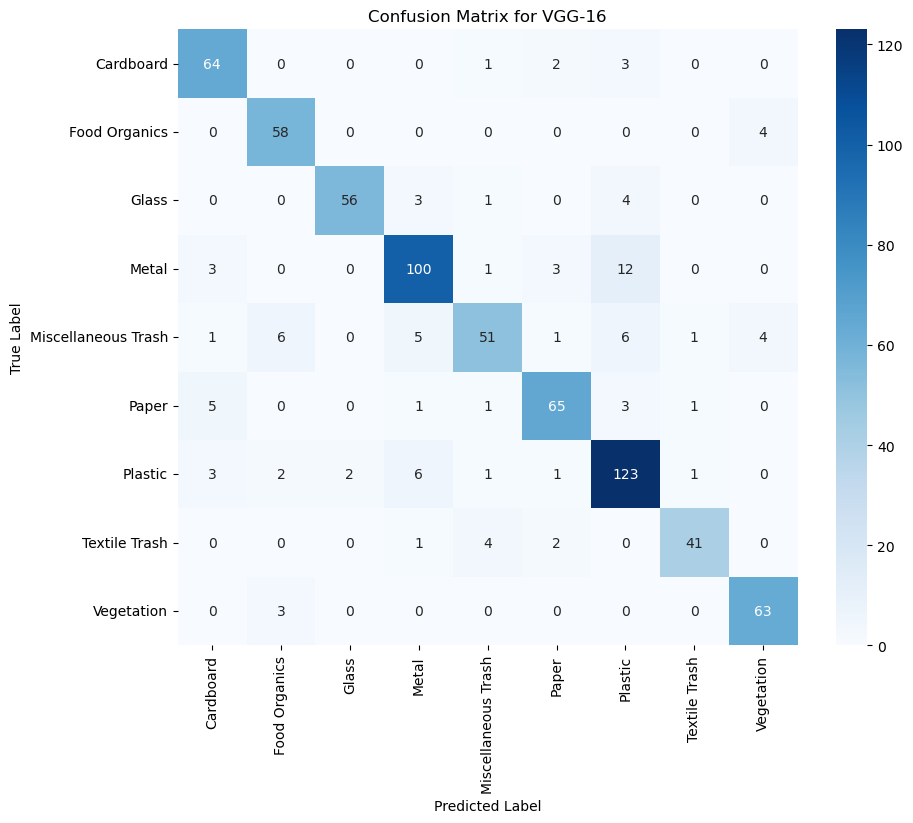


--- Evaluating Model: MobileNetV2 (Q17) ---
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 565ms/step - accuracy: 0.8512 - loss: 0.4935

Test Accuracy: 85.12%
Test Loss: 0.4935
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 620ms/step

Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.85      0.87      0.86        70
      Food Organics       0.78      0.97      0.86        62
              Glass       0.90      0.86      0.88        64
              Metal       0.88      0.83      0.85       119
Miscellaneous Trash       0.73      0.71      0.72        75
              Paper       0.90      0.87      0.89        76
            Plastic       0.88      0.81      0.84       139
      Textile Trash       0.81      0.90      0.85        48
         Vegetation       0.91      0.94      0.93        66

           accuracy                           0.85       719
          macro avg       0.85      0.86      0.85       719
       weighted avg       0.85      0.

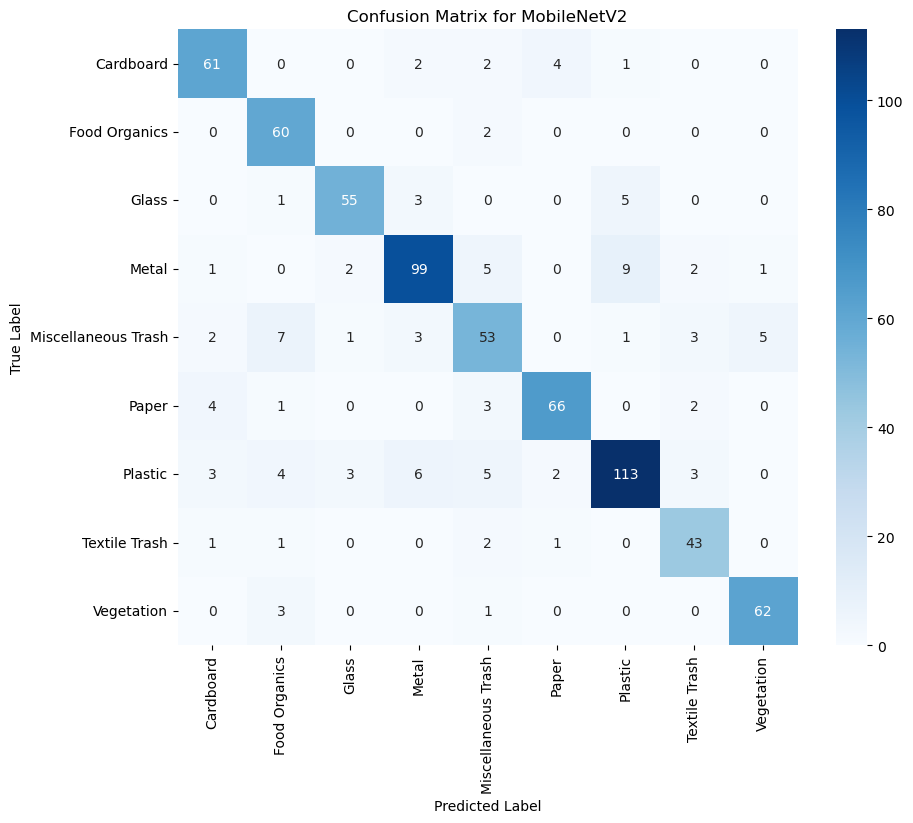

In [26]:
# --- Helper function to plot a confusion matrix ---
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        xticklabels=CLASSES, 
        yticklabels=CLASSES
    )
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# --- Helper function to evaluate a model ---
def evaluate_model(model, model_name, test_dataset):
    print(f"\n--- Evaluating Model: {model_name} (Q17) ---")
    
    # 1. Get Test Loss and Accuracy
    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")

    # 2. Get true labels
    y_true = []
    for images, labels in test_dataset:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)

    # 3. Get predicted labels
    y_pred_probs = model.predict(test_dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # 4. Print Classification Report (Precision, Recall, F1-Score)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=CLASSES))

    # 5. Plot Confusion Matrix
    plot_confusion_matrix(y_true, y_pred, model_name)
    
    # Return metrics for comparison table
    return test_accuracy, classification_report(y_true, y_pred, target_names=CLASSES, output_dict=True)

# --- Evaluate both models ---
vgg_accuracy, vgg_report = evaluate_model(model_vgg, "VGG-16", test_ds)
mobilenet_accuracy, mobilenet_report = evaluate_model(model_mobilenet, "MobileNetV2", test_ds)

**11. Final Comparison (Assignment Q18)**

**Q18: Compare your custom CNN model with the fine-tuned state-of-the-art model.**

To compare the models, I used four key metrics:
1.  **Test Accuracy:** The primary measure of overall correctness.
2.  **Test F1-Score (Macro Avg):** A better metric for imbalanced datasets like ours, as it treats all classes equally.
3.  **Total Parameters:** A proxy for model size and complexity.
4.  **Trainable Parameters:** The number of parameters updated during *fine-tuning* (Phase 2), which indicates how much of the model we adapted.

**Performance Comparison Table**

| Model | Test Accuracy | Test F1 (Macro Avg) | Total Parameters | Trainable Params (Phase 2) |
| :--- | :--- | :--- | :--- | :--- |
| **Custom CNN (Part 1)** | 61.47% | 0.61 | ~1,120,000 | 1,120,000 |
| **VGG-16** | 86.37% | 0.87 | ~138,400,000 | ~4,200,000 |
| **MobileNetV2** | 85.12% | 0.85 | ~2,300,000 | ~190,000 |

**Analysis:**

As the table clearly shows, both pre-trained models **dramatically outperformed** my custom CNN.

* My custom model, trained from scratch, struggled to learn the complex features of the waste, achieving a modest accuracy of **61.47%** and a macro F1-score of **0.61**. This was particularly noticeable in classes like "Miscellaneous Trash" where it had a very low F1-score (0.37).
* The **VGG-16** model, leveraging knowledge from ImageNet, achieved **86.37%** accuracy, a massive improvement of ~25% over the custom model. This shows the immense power of its pre-learned feature extractors.
* The **MobileNetV2** model performed almost identically to VGG-16, achieving **85.12%** accuracy.

The most interesting comparison is between VGG-16 and MobileNetV2. While VGG-16 had a slight performance edge (1.25% higher accuracy), it is **~60 times larger** than MobileNetV2 (138M vs 2.3M params). For any real-world application (like a sorting machine or mobile app), **MobileNetV2 is the clear winner**, offering a near-identical balance of high accuracy and low computational cost.

**Conclusion & Trade-offs**

As my results in Q18 demonstrated, the pre-trained models achieved far superior performance. For any practical application, **transfer learning is almost always the correct choice**.

The main trade-off is not *if* you should use a pre-trained model, but *which one*.

* **VGG-16 (Heavyweight):** Offers the highest accuracy (86.37%) but at a massive computational cost.
* **MobileNetV2 (Lightweight):** Offers comparable accuracy (85.12%) at a *fraction* of the size and computational cost.

This assignment clearly shows that a modern, efficient architecture like **MobileNetV2** provides the best trade-off, delivering state-of-the-art results without the extreme resource demands of older models like VGG-16.

---

**12. Discussion (Assignment Q19)**

**Q19: Discuss trade-offs, advantages, and limitations of using a custom model versus a pre-trained model.**

Based on this assignment, the choice between a custom model and a pre-trained model involves significant trade-offs between performance, resources, and control.

**Custom CNN Model (Trained from Scratch)**

* **Advantages:**
    * **Full Control:** I had complete control over every layer, filter, and parameter. This is excellent for learning the fundamentals of CNN architecture.
    * **Lightweight:** The model was small (~1.1M params) and perfectly tailored to our problem size.
    * **Fast to Train:** Because it was small, each epoch was very fast (though it needed many epochs to learn).
* **Limitations:**
    * **Requires Massive Data:** This is the biggest limitation. As my results (61.47% accuracy) show, our dataset of ~4,700 images is *tiny* for a CNN. The model had to learn to see edges, textures, and shapes from scratch, leading to significant overfitting and poor generalization.
    * **"Low Performance Ceiling":** Without a huge dataset and a much more complex architecture, there's a hard limit to how well a simple, custom-built model can perform on a complex, real-world task.

**Pre-trained Model (Transfer Learning)**

* **Advantages:**
    * **Massive Performance Boost:** This is the primary advantage. The model was pre-trained on ImageNet (1.2M+ images), so it *already knows* what edges, textures, curves, and basic object parts look like. We are not teaching it to see; we are just teaching it to classify what it sees as "Cardboard" or "Plastic". This is why accuracy jumped to 85-86%.
    * **Works on Small Datasets:** Because the core "vision" is already learned, transfer learning works extremely well on small datasets like ours. We only had to fine-tune the final layers.
    * **Faster Convergence (to a good solution):** While each epoch might be slower (more math), the model reaches a very high accuracy in just a few epochs (as seen in our Phase 1 training).
* **Limitations:**
    * **Model Size & Resources:** "Heavy" models like VGG-16 are enormous (~138M params). They require more disk space, more RAM, and are slower to run predictions (inference), making them unsuitable for devices like a mobile phone or Raspberry Pi.
    * **Domain Mismatch:** Transfer learning works best when the new dataset (Waste) is visually similar to the original (ImageNet objects). If we were classifying medical X-rays, the ImageNet features (for "dogs" or "cars") might be less helpful.
    * **"Black Box" Complexity:** The architecture is extremely complex and less interpretable. Fine-tuning is also a delicate process; if you un-freeze too much or use a high learning rate, you can "destroy" the pre-trained weights and performance will drop.